In [1]:
# Crafted by Collin Miller

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import bisect
import cv2
import h5py
import keras
from models import ChopinNet
from models import BachNet

import networkx as nx
import numpy as np
import os
import re
import sys
import time


from heapq import heappop as pop
from heapq import heappush as push
from utils import graph_utils
from utils import display_utils
from utils import prediction_utils
from utils import preprocessing_utils
from utils import relative_assignments

Using TensorFlow backend.


In [5]:
from skimage import io

In [6]:
from utils.prediction_utils import input_generator

In [7]:
train_path = "data/train"
test_path = "data/test"

input_path = "input"
output_path = "output"

gt_tag = "gt"


receptive_field_shape = (12, 12)
n_epochs = 32

In [8]:
bach = BachNet.BachNet()
bach.build(receptive_field_shape, 1)
bach.load_model('models/saved_models/Bach/model.h5')

batch = dict()
input_gen = prediction_utils.input_generator(bach, train_path, input_path, gt_tag)

while True:
    try:
        f_name, img, bps, I_a, gt, gt_cuts, seeds = next(input_gen)
        graph = graph_utils.prims_initialize(img)
        batch[f_name] = img, bps, I_a, gt, gt_cuts, seeds, graph
    except StopIteration:
        break

Loading image:  530_1100
Loading image:  530_1100
Loading image:  310_570
Loading image:  310_570
Loading image:  550_1080
Loading image:  550_1080
Loading image:  570_342_gt
Loading image:  550_1080_gt
Loading image:  740_1450_gt
Loading image:  640_1160_gt
Loading image:  350_710_gt
Loading image:  350_710
Loading image:  350_710
Loading image:  710_1450_gt
Loading image:  470_860
Loading image:  470_860
Loading image:  310_560
Loading image:  310_560
Loading image:  720_392_gt
Loading image:  710_1470
Loading image:  710_1470
Loading image:  640_1140_gt
Loading image:  620_1150_gt
Loading image:  630_1160
Loading image:  630_1160
Loading image:  310_560_gt
Loading image:  750_146
Loading image:  750_146
Loading image:  540_1080
Loading image:  540_1080
Loading image:  350_720_gt
Loading image:  720_1470_gt
Loading image:  730_1440_gt
Loading image:  730_1450_gt
Loading image:  630_1150_gt
Loading image:  530_1080_gt
Loading image:  630_1150
Loading image:  630_1150
Loading image:  5

In [9]:
chopin = ChopinNet.Chopin()
chopin.build(receptive_field_shape, learning_rate=1e-6)
#chopin.load_model("models/saved_model/Chopin/checkpoint")
chopin.initialize_session()

In [10]:
global_loss_timeline = []
loss_timelines = dict()
loss_file = open("data/train/chopin/global_loss.txt", 'w')
loss_file.write("f_name\tepoch\tloss\n")

for f_name, (img, bps, I_a, gt, gt_cuts, seeds, graph) in batch.iteritems():
    print("Training on", f_name)
    foldername = os.path.join(train_path, "chopin", f_name)
    for epoch in range(n_epochs):
        start = time.time()

Training on 730_1460
Training on 710_1440
Training on 540_1090
Training on 730_1440
Training on 530_1100
Training on 733_374
Training on 480_850
Training on 650_1140
Training on 630_1160
Training on 730_1470
Training on 470_850
Training on 350_710
Training on 630_1140
Training on 750_146
Training on 710_1460
Training on 700_1460
Training on 530_1080
Training on 360_720
Training on 740_1460
Training on 640_1150
Training on 310_560
Training on 540_1100
Training on 720_1450
Training on 710_1470
Training on 260_1490
Training on 550_1090
Training on 720_1470
Training on 480_860
Training on 650_1150
Training on 710_1450
Training on 620_1150
Training on 540_1080
Training on 470_860
Training on 720_392
Training on 730_1450
Training on 700_1450
Training on 630_1150
Training on 260_1500
Training on 570_342
Training on 640_1160
Training on 530_1090
Training on 740_1450
Training on 350_720
Training on 720_1460
Training on 310_570
Training on 640_1140
Training on 620_1140
Training on 550_1080
Train

720_1440


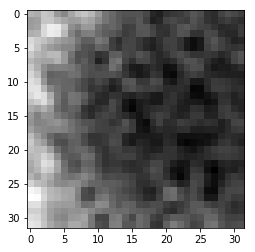

In [11]:
print(f_name)
plt.imshow(img, cmap='gray')

In [22]:
msf = chopin.predicted_msf(I_a, graph, seeds)
segmentations = display_utils.assignments(np.zeros_like(img), msf, seeds)

shortest_paths = nx.get_node_attributes(msf, 'path')
assignments = nx.get_node_attributes(msf, 'seed')
cuts = graph_utils.get_cut_edges(msf)

constrained_msf = msf.copy()

constrained_msf.remove_edges_from(gt_cuts)

constrained_msf = graph_utils.minimum_spanning_forest(img, constrained_msf, seeds)

ground_truth_paths = nx.get_node_attributes(constrained_msf, 'path')

children = graph_utils.compute_root_error_edge_children(shortest_paths,
                                                  ground_truth_paths, cuts,
                                                  gt_cuts)

weights = []
static_images = []
dynamic_images = []

for (u, v), weight in children.iteritems():

    try:
        static_images.append(msf.get_edge_data(u, v)['static_image'])
        dynamic_images.append(msf.get_edge_data(u, v)['dynamic_image'])
        weights.append(weight)
        altitude_val = msf.get_edge_data(u, v)['weight']
    except KeyError:
        pass

batches = zip(preprocessing_utils.create_batches(np.expand_dims(np.stack(weights), 1)),
              preprocessing_utils.create_batches(np.stack(static_images)),
              preprocessing_utils.create_batches(np.stack(dynamic_images)))


with chopin.sess.as_default():
    chopin.sess.run(chopin.zero_ops)

    for w, s, d in batches:
        feed_dict = {chopin.gradient_weights: w.transpose(),
                     chopin.static_input: s,
                     chopin.dynamic_input: d,
                     keras.backend.learning_phase(): 0}

        chopin.sess.run(chopin.accum_ops, feed_dict)
        loss = chopin.sess.run(chopin.loss, feed_dict)
        loss = loss[0][0]

    chopin.sess.run(chopin.train_step)

Starting gradient segmentation...
Segmentation done: 2.962400s


In [23]:
loss

-12.561777

In [24]:
w

array([[   1],
       [  -2],
       [   5],
       [  -1],
       [  -1],
       [   4],
       [  -4],
       [  -1],
       [  -1],
       [ -11],
       [  -1],
       [  -1],
       [ -22],
       [  -1],
       [-386],
       [  -6],
       [  -8],
       [   1],
       [   1],
       [  -1]])

In [12]:
msf = graph

In [52]:
batches

[(array([[   1],
         [  -2],
         [   5],
         [  -1],
         [  -1],
         [   4],
         [  -4],
         [  -1],
         [  -1],
         [ -11],
         [  -1],
         [  -1],
         [ -22],
         [  -1],
         [-386],
         [  -6],
         [  -8],
         [   1],
         [   1],
         [  -1]]), array([[[[  1.37000000e+02,   5.34221035e-05],
           [  1.41000000e+02,   9.70313522e-06],
           [  1.54000000e+02,   2.67017051e-04],
           ..., 
           [  9.30000000e+01,   4.39162484e-09],
           [  7.10000000e+01,   6.56272611e-03],
           [  6.00000000e+01,   4.59743477e-02]],
  
          [[  1.30000000e+02,   4.75021043e-05],
           [  1.40000000e+02,   1.39994430e-04],
           [  1.60000000e+02,   3.63052532e-04],
           ..., 
           [  8.80000000e+01,   5.56468760e-10],
           [  7.10000000e+01,   2.79471686e-04],
           [  6.00000000e+01,   8.42718175e-04]],
  
          [[  1.27000000e+02, 

In [65]:
w

array([[   1],
       [  -2],
       [   5],
       [  -1],
       [  -1],
       [   4],
       [  -4],
       [  -1],
       [  -1],
       [ -11],
       [  -1],
       [  -1],
       [ -22],
       [  -1],
       [-386],
       [  -6],
       [  -8],
       [   1],
       [   1],
       [  -1]])

In [64]:
chopin.predict_altitudes(s, d)

array([[ 0.16700763],
       [ 0.09750231],
       [ 0.20233563],
       [ 0.20606384],
       [ 0.22383538],
       [ 0.01221611],
       [ 0.11864576],
       [ 0.22002317],
       [ 0.12304842],
       [ 0.10475013],
       [ 0.13650662],
       [ 0.16387045],
       [ 0.14927152],
       [ 0.13049819],
       [ 0.08642274],
       [ 0.17035477],
       [ 0.1369762 ],
       [ 0.1062852 ],
       [-0.0049575 ],
       [ 0.15606013]], dtype=float32)

In [63]:
chopin.predict_altitudes(s, d) * w

array([[  1.67007625e-01],
       [ -1.95004612e-01],
       [  1.01167813e+00],
       [ -2.06063837e-01],
       [ -2.23835379e-01],
       [  4.88644540e-02],
       [ -4.74583060e-01],
       [ -2.20023170e-01],
       [ -1.23048425e-01],
       [ -1.15225139e+00],
       [ -1.36506617e-01],
       [ -1.63870454e-01],
       [ -3.28397340e+00],
       [ -1.30498186e-01],
       [ -3.33591782e+01],
       [ -1.02212861e+00],
       [ -1.09580958e+00],
       [  1.06285200e-01],
       [ -4.95749712e-03],
       [ -1.56060129e-01]])

In [15]:
msf

In [16]:
msf.edge[(16, 3)][(16, 2)]

{'dynamic_image': array([[[ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.]],
 
        [[ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.]],
 
        [[ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.]],
 
        [[ 0.,  0.,  1.],
         [ 0

In [37]:
weights

[-1,
 -73,
 -2,
 1,
 -1,
 -33,
 -9,
 -1,
 -4,
 -1,
 -1,
 -52,
 -1,
 -3,
 -2,
 -1,
 -3,
 -1,
 -4,
 -2,
 -5]

In [36]:
w

array([[ -1],
       [-73],
       [ -2],
       [  1],
       [ -1],
       [-33],
       [ -9],
       [ -1],
       [ -4],
       [ -1],
       [ -1],
       [-52],
       [ -1],
       [ -3],
       [ -2],
       [ -1],
       [ -3],
       [ -1],
       [ -4],
       [ -2],
       [ -5]])

In [25]:
T = nx.get_node_attributes(msf, 'path')

In [26]:
T_star = nx.get_node_attributes(constrained_msf, 'path')

In [48]:
for node, path in T.iteritems():
    shortest_path = T[node]
    ground_truth_path = T_star[node]
    if shortest_path != ground_truth_path:
        print("Woah There")
        print(shortest_path)
        print()
        print(ground_truth_path)
        break

Woah There
[(15, 3), (15, 2), (15, 1), (14, 1), (14, 0), (13, 0), (12, 0), (12, 1), (11, 1), (11, 2), (10, 2), (10, 3), (10, 4), (10, 5), (9, 5), (9, 6), (8, 6), (8, 7), (8, 8), (7, 8), (7, 9), (7, 10), (8, 10), (8, 11), (8, 12), (9, 12), (10, 12), (11, 12), (12, 12), (13, 12), (13, 13), (13, 14), (13, 15), (12, 15), (12, 16), (12, 17), (12, 18), (12, 19), (12, 20), (11, 20), (10, 20), (9, 20), (8, 20), (8, 21), (7, 21), (7, 22), (8, 22), (8, 23), (8, 24), (8, 25), (8, 26), (8, 27), (7, 27), (7, 28), (7, 29), (6, 29), (6, 30), (5, 30), (5, 31)]

[(15, 18), (15, 17), (15, 16), (15, 15), (14, 15), (14, 14), (13, 14), (13, 15), (12, 15), (12, 16), (12, 17), (12, 18), (12, 19), (12, 20), (11, 20), (10, 20), (9, 20), (8, 20), (8, 21), (7, 21), (7, 22), (8, 22), (8, 23), (8, 24), (8, 25), (8, 26), (8, 27), (7, 27), (7, 28), (7, 29), (6, 29), (6, 30), (5, 30), (5, 31)]


In [28]:
short_weights = nx.get_edge_attributes(msf, 'weight')

In [29]:
short_weights

{((2, 21), (2, 22)): 0.032823455,
 ((1, 21), (2, 21)): 0.058926109,
 ((6, 12), (6, 13)): 0.036701638,
 ((4, 29), (3, 29)): 0.041362479,
 ((1, 22), (2, 22)): 0.049327508,
 ((17, 27), (17, 26)): 0.043295108,
 ((10, 10), (9, 10)): 0.07611122,
 ((9, 26), (9, 25)): 0.066438667,
 ((25, 27), (25, 28)): 0.051698934,
 ((24, 14), (23, 14)): 0.11951403,
 ((28, 19), (28, 18)): 0.069858506,
 ((13, 7), (13, 8)): 0.053345665,
 ((12, 15), (13, 15)): 0.04956115,
 ((14, 28), (14, 27)): 0.053242266,
 ((22, 23), (23, 23)): 0.04856436,
 ((26, 19), (27, 19)): 0.024692854,
 ((22, 12), (22, 11)): 0.062361147,
 ((1, 12), (0, 12)): 0.10470749,
 ((10, 3), (10, 4)): -0.0233922,
 ((15, 18), (15, 17)): 0.020005085,
 ((11, 12), (11, 13)): 0.0091287848,
 ((3, 4), (4, 4)): 0.07024914,
 ((7, 25), (8, 25)): 0.026225381,
 ((28, 26), (27, 26)): 0.044420779,
 ((31, 23), (31, 22)): 0.035472784,
 ((8, 26), (7, 26)): 0.0022133831,
 ((27, 1), (26, 1)): -0.023192942,
 ((5, 13), (5, 14)): 0.063303038,
 ((30, 0), (29, 0)): -0.030

In [30]:
shortest_path

[(15, 3),
 (15, 2),
 (15, 1),
 (14, 1),
 (14, 0),
 (13, 0),
 (12, 0),
 (12, 1),
 (11, 1),
 (11, 2),
 (10, 2),
 (10, 3),
 (10, 4),
 (10, 5),
 (9, 5),
 (9, 6),
 (8, 6),
 (8, 7),
 (8, 8),
 (7, 8),
 (7, 9),
 (7, 10),
 (8, 10),
 (8, 11),
 (8, 12),
 (9, 12),
 (10, 12),
 (11, 12),
 (12, 12),
 (13, 12),
 (13, 13),
 (13, 14),
 (13, 15),
 (12, 15),
 (12, 16),
 (12, 17),
 (12, 18),
 (12, 19),
 (12, 20),
 (11, 20),
 (10, 20),
 (9, 20),
 (8, 20),
 (8, 21),
 (7, 21),
 (7, 22),
 (8, 22),
 (8, 23),
 (8, 24),
 (8, 25),
 (8, 26),
 (8, 27),
 (7, 27),
 (7, 28),
 (7, 29),
 (6, 29),
 (6, 30),
 (5, 30),
 (5, 31)]

In [31]:
def path_alt(path):
    altitudes = []
    for x in xrange(len(path) - 1):
        u = path[x]
        v = path[x+1]
        weight = msf.edge[u][v]['weight']
        altitudes.append(weight)
    return max(altitudes)

In [32]:
for seed in seeds:
    del T[seed]

In [33]:
fucks = 0
for node, path in T.iteritems():
    shortest_path = T[node]
    ground_truth_path = T_star[node]
    t = path_alt(shortest_path)
    t_star = path_alt(ground_truth_path)
    fucks += t_star - t
    
#     if shortest_path != ground_truth_path:
        
#         if t_star <= t:
#             print("Woah There.")
#             fucks += 1

In [34]:
loss

-12.561777

In [35]:
fucks

1.2139445059001446

In [74]:
(fucks / msf.number_of_nodes()) * 100

1.1342096549924463

In [36]:
node

(19, 30)

In [37]:
seeds

[(15, 3), (15, 18)]

In [51]:
print(t, t_star, t_star - t)

0.0563437 0.0563437 0.0


In [52]:
(15, 18) in shortest_path

False

In [31]:
shortest_path

[(15, 3),
 (15, 2),
 (15, 1),
 (14, 1),
 (14, 0),
 (13, 0),
 (12, 0),
 (11, 0),
 (10, 0),
 (9, 0),
 (8, 0),
 (8, 1),
 (7, 1),
 (6, 1),
 (5, 1),
 (4, 1),
 (4, 2),
 (3, 2),
 (3, 3),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 8),
 (4, 8),
 (4, 9),
 (5, 9),
 (5, 10),
 (6, 10),
 (6, 11),
 (5, 11),
 (4, 11),
 (4, 12),
 (4, 13),
 (4, 14),
 (5, 14),
 (6, 14),
 (7, 14),
 (7, 13),
 (8, 13),
 (9, 13),
 (9, 14),
 (9, 15),
 (9, 16),
 (8, 16),
 (8, 17),
 (8, 18),
 (8, 19),
 (8, 20),
 (8, 21),
 (8, 22),
 (9, 22),
 (9, 23),
 (10, 23),
 (10, 24),
 (11, 24),
 (12, 24),
 (12, 25),
 (12, 26),
 (13, 26),
 (13, 27),
 (14, 27),
 (14, 28),
 (15, 28),
 (16, 28),
 (17, 28),
 (17, 27),
 (18, 27),
 (18, 28),
 (18, 29),
 (18, 30),
 (19, 30)]

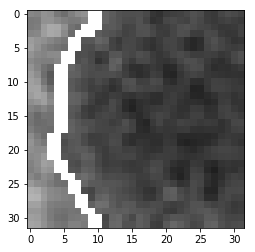

In [40]:
plt.imshow(display_utils.view_boundaries(img, gt_cuts))

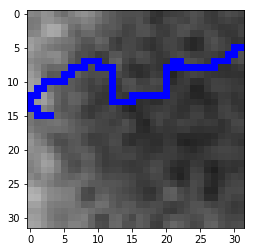

In [49]:
display_utils.view_path(img, shortest_path)

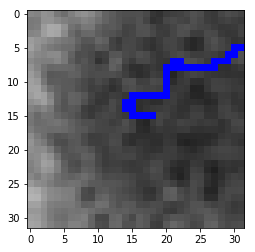

In [50]:
display_utils.view_path(img, ground_truth_path)

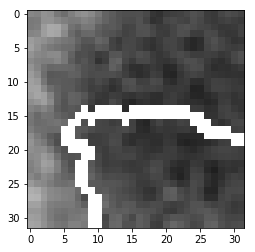

In [43]:
plt.imshow(display_utils.view_boundaries(img, cuts))

In [44]:
ground_truth_path

[(15, 18),
 (15, 19),
 (16, 19),
 (16, 20),
 (16, 21),
 (16, 22),
 (16, 23),
 (16, 24),
 (16, 25),
 (17, 25),
 (18, 25),
 (19, 25),
 (20, 25),
 (21, 25),
 (22, 25),
 (22, 26),
 (22, 27),
 (22, 28),
 (22, 29),
 (21, 29),
 (21, 30),
 (20, 30),
 (19, 30)]

In [47]:
ground_truth_path == shortest_path

True

In [87]:
for i, node in enumerate(xrange(len(shortest_path) - 1)):
    u = shortest_path[i]
    v = shortest_path[i+1]
    if (u, v) in gt_cuts or (v, u) in gt_cuts:
        print(u,v)

(3, 7) (3, 8)


In [45]:
def find_missing_cut(shortest_path, ground_truth_cuts):
    """
    Computes the root error missing cut of a shortest path.

    Every incorrect shortest path has at least one erroneous cut edge.  The first such
    edge shall be called the path's root error edge p(w) and is always a missing cut.

    Args:
        shortest_path (list): The list of edges in the shortest path.
        ground_truth_cuts (list): The list ground truth cuts for the ground truth segmentation.

    Returns:
        tuple: The first erroneous cut edge in the shortest path.
    """

    for i, node in enumerate(xrange(len(shortest_path) - 1)):
        u = shortest_path[i]
        v = shortest_path[i+1]
        if (u, v) in ground_truth_cuts or (v, u) in ground_truth_cuts:
                return (u, v)

In [46]:
find_missing_cut(shortest_path, gt_cuts)

In [40]:
t

-0.18847299

In [41]:
ground_truth_path

[(15, 18),
 (15, 19),
 (15, 20),
 (16, 20),
 (17, 20),
 (18, 20),
 (18, 19),
 (18, 18),
 (18, 17),
 (18, 16),
 (19, 16),
 (19, 15),
 (19, 14),
 (20, 14),
 (20, 13),
 (21, 13),
 (21, 12),
 (22, 12),
 (22, 11),
 (23, 11),
 (23, 10),
 (24, 10),
 (24, 9),
 (24, 8),
 (24, 7),
 (25, 7),
 (26, 7),
 (26, 8),
 (26, 9),
 (26, 10),
 (27, 10),
 (27, 11),
 (27, 12),
 (27, 13),
 (27, 14),
 (26, 14),
 (25, 14),
 (24, 14),
 (24, 15),
 (24, 16),
 (24, 17),
 (24, 18),
 (23, 18),
 (23, 19),
 (23, 20),
 (23, 21),
 (23, 22),
 (24, 22),
 (25, 22),
 (26, 22),
 (26, 23),
 (26, 24),
 (25, 24),
 (25, 25),
 (24, 25),
 (24, 26),
 (24, 27),
 (24, 28),
 (23, 28),
 (23, 27),
 (23, 26),
 (22, 26),
 (22, 25),
 (21, 25),
 (20, 25)]

In [42]:
t_star

-0.18847299

In [26]:

altitudes = []
for x in xrange(len(shortest_path) - 1):
    u = shortest_path[x]
    v = shortest_path[x+1]
    weight = msf.edge[u][v]['weight']
    altitudes.append(weight)
    print(u, v, max(altitudes))

(15, 3) (16, 3) -0.338751
(16, 3) (16, 2) -0.338751
(16, 2) (17, 2) -0.338751
(17, 2) (18, 2) -0.338751
(18, 2) (19, 2) -0.338751
(19, 2) (19, 1) -0.338751
(19, 1) (18, 1) -0.338751
(18, 1) (17, 1) -0.338751
(17, 1) (16, 1) -0.338751
(16, 1) (16, 0) -0.338751
(16, 0) (15, 0) -0.338751
(15, 0) (14, 0) -0.338751
(14, 0) (13, 0) -0.331402
(13, 0) (12, 0) -0.331402
(12, 0) (11, 0) -0.331402
(11, 0) (11, 1) -0.331402
(11, 1) (10, 1) -0.331402
(10, 1) (10, 2) -0.331402
(10, 2) (9, 2) -0.331402
(9, 2) (8, 2) -0.331402
(8, 2) (7, 2) -0.322
(7, 2) (7, 1) -0.319958
(7, 1) (7, 0) -0.319958
(7, 0) (6, 0) -0.319958
(6, 0) (6, 1) -0.319958
(6, 1) (5, 1) -0.306769
(5, 1) (5, 2) -0.28554
(5, 2) (4, 2) -0.28554
(4, 2) (3, 2) -0.28554
(3, 2) (2, 2) -0.28554
(2, 2) (1, 2) -0.28554
(1, 2) (0, 2) -0.28554
(0, 2) (0, 3) -0.28554
(0, 3) (0, 4) -0.28554
(0, 4) (0, 5) -0.28554
(0, 5) (0, 6) -0.28554
(0, 6) (0, 7) -0.28554
(0, 7) (1, 7) -0.28554
(1, 7) (1, 8) -0.28554
(1, 8) (0, 8) -0.28554
(0, 8) (0, 9) -0.271

In [24]:
msf.edge[(15, 3)][(16, 3)]['weight']

-0.33875138

In [22]:
ra.padded_ras.shape

(2, 44, 44, 3)

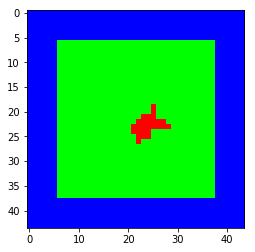

In [23]:
plt.imshow(ra.padded_ras[0])

In [24]:
assignments = nx.get_node_attributes(graph, 'seed')

In [25]:
segmentations = display_utils.assignments(np.zeros_like(img), graph, seeds)

In [26]:
seeds

[(15, 3), (15, 18)]

In [27]:
assignments[(0,0)]

(15, 3)

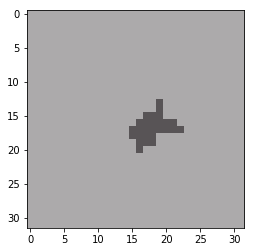

In [20]:
plt.imshow(segmentations)

In [29]:
for node in graph.nodes_iter(data=True):
    print(node)

((31, 6), {'path': [(15, 3), (16, 3), (16, 4), (17, 4), (17, 5), (18, 5), (18, 6), (19, 6), (20, 6), (20, 7), (21, 7), (21, 6), (22, 6), (23, 6), (23, 5), (23, 4), (23, 3), (24, 3), (25, 3), (25, 4), (26, 4), (27, 4), (28, 4), (29, 4), (30, 4), (31, 4), (31, 5), (31, 6)], 'seed': (15, 3)})
((21, 28), {'path': [(15, 3), (16, 3), (16, 4), (17, 4), (17, 5), (18, 5), (18, 6), (19, 6), (20, 6), (20, 7), (21, 7), (21, 6), (22, 6), (23, 6), (23, 5), (23, 4), (23, 3), (24, 3), (25, 3), (25, 4), (26, 4), (27, 4), (28, 4), (29, 4), (30, 4), (31, 4), (31, 5), (31, 6), (30, 6), (30, 7), (30, 8), (30, 9), (30, 10), (29, 10), (29, 11), (29, 12), (28, 12), (28, 13), (28, 14), (27, 14), (26, 14), (26, 15), (25, 15), (25, 16), (25, 17), (26, 17), (27, 17), (28, 17), (29, 17), (29, 18), (29, 19), (29, 20), (29, 21), (28, 21), (28, 22), (28, 23), (27, 23), (27, 24), (26, 24), (25, 24), (24, 24), (23, 24), (23, 25), (23, 26), (22, 26), (22, 27), (21, 27), (21, 28)], 'seed': (15, 3)})
((7, 25), {'path': [(

In [15]:
num_nodes = msf.number_of_nodes()
visited = np.zeros(I_a.shape[:-1])
frontier = []

ra = relative_assignments.RelativeAssignments(seeds,
                                              (I_a.shape[0],
                                               I_a.shape[1]),
                                              chopin.receptive_field_shape)
static_input_images = preprocessing_utils.prepare_input_images(I_a, height=chopin.receptive_field_shape[0],
                                                               width=chopin.receptive_field_shape[1])
print("Starting gradient segmentation...")
start = time.time()

for u in seeds:

    # Assign seed to chopin.
    msf.node[u]['seed'] = u

    ra.assign_node(u, seeds.index(u))

    visited[u[0], u[1]] = 1

    # Store path.
    msf.node[u]['path'] = [u]

    # Push all edges
    static_input = []
    dynamic_input = []
    edges = []
    for u, v in msf.edges(u):
        edges.append((u, v))
        seed_index = seeds.index(msf.node[u]['seed'])
        static_image = static_input_images[v[0] * I_a.shape[1] + v[1]]
        dynamic_image = ra.prepare_images([(u, seed_index)])[0]
        static_input.append(static_image)
        dynamic_input.append(dynamic_image)
        msf.edge[u][v]['static_image'] = static_image
        msf.edge[u][v]['dynamic_image'] = dynamic_image

    static_input = np.stack(static_input)
    dynamic_input = np.stack(dynamic_input)

    altitude_values = chopin.predict_altitudes(static_input,
                                              dynamic_input)

    for (u, v), alt in zip(edges, altitude_values):
        msf.edge[u][v]['weight'] = alt[0]
        push(frontier, (alt, u, v))

while frontier:
    W, u, v = pop(frontier)


    if visited[v[0], v[1]] == 1:
        continue

    # Assign the node
    msf.node[v]['seed'] = msf.node[u]['seed']

    ra.assign_node(v, seeds.index(msf.node[u]['seed']))

    # Store path.
    msf.node[v]['path'] = msf.node[u]['path'] + [v]

    visited[v[0], v[1]] = 1


    static_input = []
    dynamic_input = []
    edges = []
    for v, w in msf.edges(v):
        if visited[w[0], w[1]] == 0:
            edges.append((v, w))
            seed_index = seeds.index(msf.node[v]['seed'])
            static_image = static_input_images[w[0] * I_a.shape[1] + w[1]]
            dynamic_image = ra.prepare_images([(v, seed_index)])[0]
            static_input.append(static_image)
            dynamic_input.append(dynamic_image)
            msf.edge[u][v]['static_image'] = static_image
            msf.edge[u][v]['dynamic_image'] = dynamic_image

    try:
        static_input = np.stack(static_input)
        dynamic_input = np.stack(dynamic_input)

        altitude_values = chopin.predict_altitudes(static_input,
                                                  dynamic_input)

        for (v, w), alt in zip(edges, altitude_values):
            msf.edge[v][w]['weight'] = alt[0]
            push(frontier, (alt, v, w))
    except ValueError:
        pass

end = time.time()
print("Segmentation done: %fs" % (end - start))



segmentations = display_utils.assignments(np.zeros_like(img), msf, seeds)

shortest_paths = nx.get_node_attributes(msf, 'path')
assignments = nx.get_node_attributes(msf, 'seed')
cuts = graph_utils.get_cut_edges(msf)

constrained_msf = msf.copy()

constrained_msf.remove_edges_from(gt_cuts)

constrained_msf = graph_utils.minimum_spanning_forest(img, constrained_msf, seeds)

ground_truth_paths = nx.get_node_attributes(constrained_msf, 'path')

children = graph_utils.compute_root_error_edge_children(shortest_paths,
                                                  ground_truth_paths, cuts,
                                                  gt_cuts)

weights = []
static_images = []
dynamic_images = []

for (u, v), weight in children.iteritems():
    try:
        static_images.append(msf.get_edge_data(u, v)['static_image'])
        dynamic_images.append(msf.get_edge_data(u, v)['dynamic_image'])
        weights.append(weight)
        altitude_val = msf.get_edge_data(u, v)['weight']
    except KeyError:
        print(u, v, weight)

batches = zip(preprocessing_utils.create_batches(np.expand_dims(np.stack(weights), 1)),
              preprocessing_utils.create_batches(np.stack(static_images)),
              preprocessing_utils.create_batches(np.stack(dynamic_images)))

loss = 0
with chopin.sess.as_default():
    chopin.sess.run(chopin.zero_ops)

    for w, s, d in batches:
        feed_dict = {chopin.gradient_weights: w.transpose(),
                     chopin.static_input: s,
                     chopin.dynamic_input: d,
                     keras.backend.learning_phase(): 0}

        chopin.sess.run(chopin.accum_ops, feed_dict)
        loss = chopin.sess.run(chopin.loss, feed_dict)
        loss += loss[0][0]

    chopin.sess.run(chopin.train_step)

(17, 16) (18, 16) 780
(30, 9) (31, 9) 1
